**PREDICT THE BURNED AREA OF FOREST FIRES WITH NEURAL NETWORKS**

**Attributes**:

month month of the year: 'jan' to 'dec'

day :: day of the week: 'mon' to 'sun'

FFMC ::FFMC index from the FWI system: 18.7 to 96.20

DMC :: DMC index from the FWI system: 1.1 to 291.3

DC ::DC index from the FWI system: 7.9 to 860.6

ISI ::ISI index from the FWI system: 0.0 to 56.10

temp:: temperature in Celsius degrees: 2.2 to 33.30

RH ::relative humidity in %: 15.0 to 100

wind ::wind speed in km/h: 0.40 to 9.40

rain ::outside rain in mm/m2 : 0.0 to 6.4

Size_Categorie the burned area of the forest ( Small , Large)



In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split

import warnings
warnings.filterwarnings('ignore')

from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression 

In [2]:
#Loading data
data = pd.read_csv('/content/forestfires.csv')
data.head() 

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small


In [3]:

# dropping encoded columns
raw_data = data[['month', 'day','FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area', 'size_category' ]]
raw_data.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,small


In [4]:
print(data.shape)
print(raw_data.shape) 

(517, 31)
(517, 12)


**Descriptive Statistics**

In [5]:
raw_data.isna().sum().sum() 

0

In [6]:

raw_data.describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [7]:
raw_data.info()
     

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  size_category  517 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 48.6+ KB


In [8]:
#Numeric_variables

numeric_features = [feature for feature in raw_data.columns if raw_data[feature].dtypes != 'O']
print('numeric features:', numeric_features, '\n') 

numeric features: ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area'] 



In [9]:
#categorical_variables

categorical_features = [feature for feature in raw_data.columns if raw_data[feature].dtypes == 'O']
print('categorical_features:', categorical_features) 

categorical_features: ['month', 'day', 'size_category']


In [10]:
#Corrrelation

raw_data.corr()['area'].sort_values(ascending=False)

area    1.000000
temp    0.097844
DMC     0.072994
DC      0.049383
FFMC    0.040122
wind    0.012317
ISI     0.008258
rain   -0.007366
RH     -0.075519
Name: area, dtype: float64

**Visualisation**

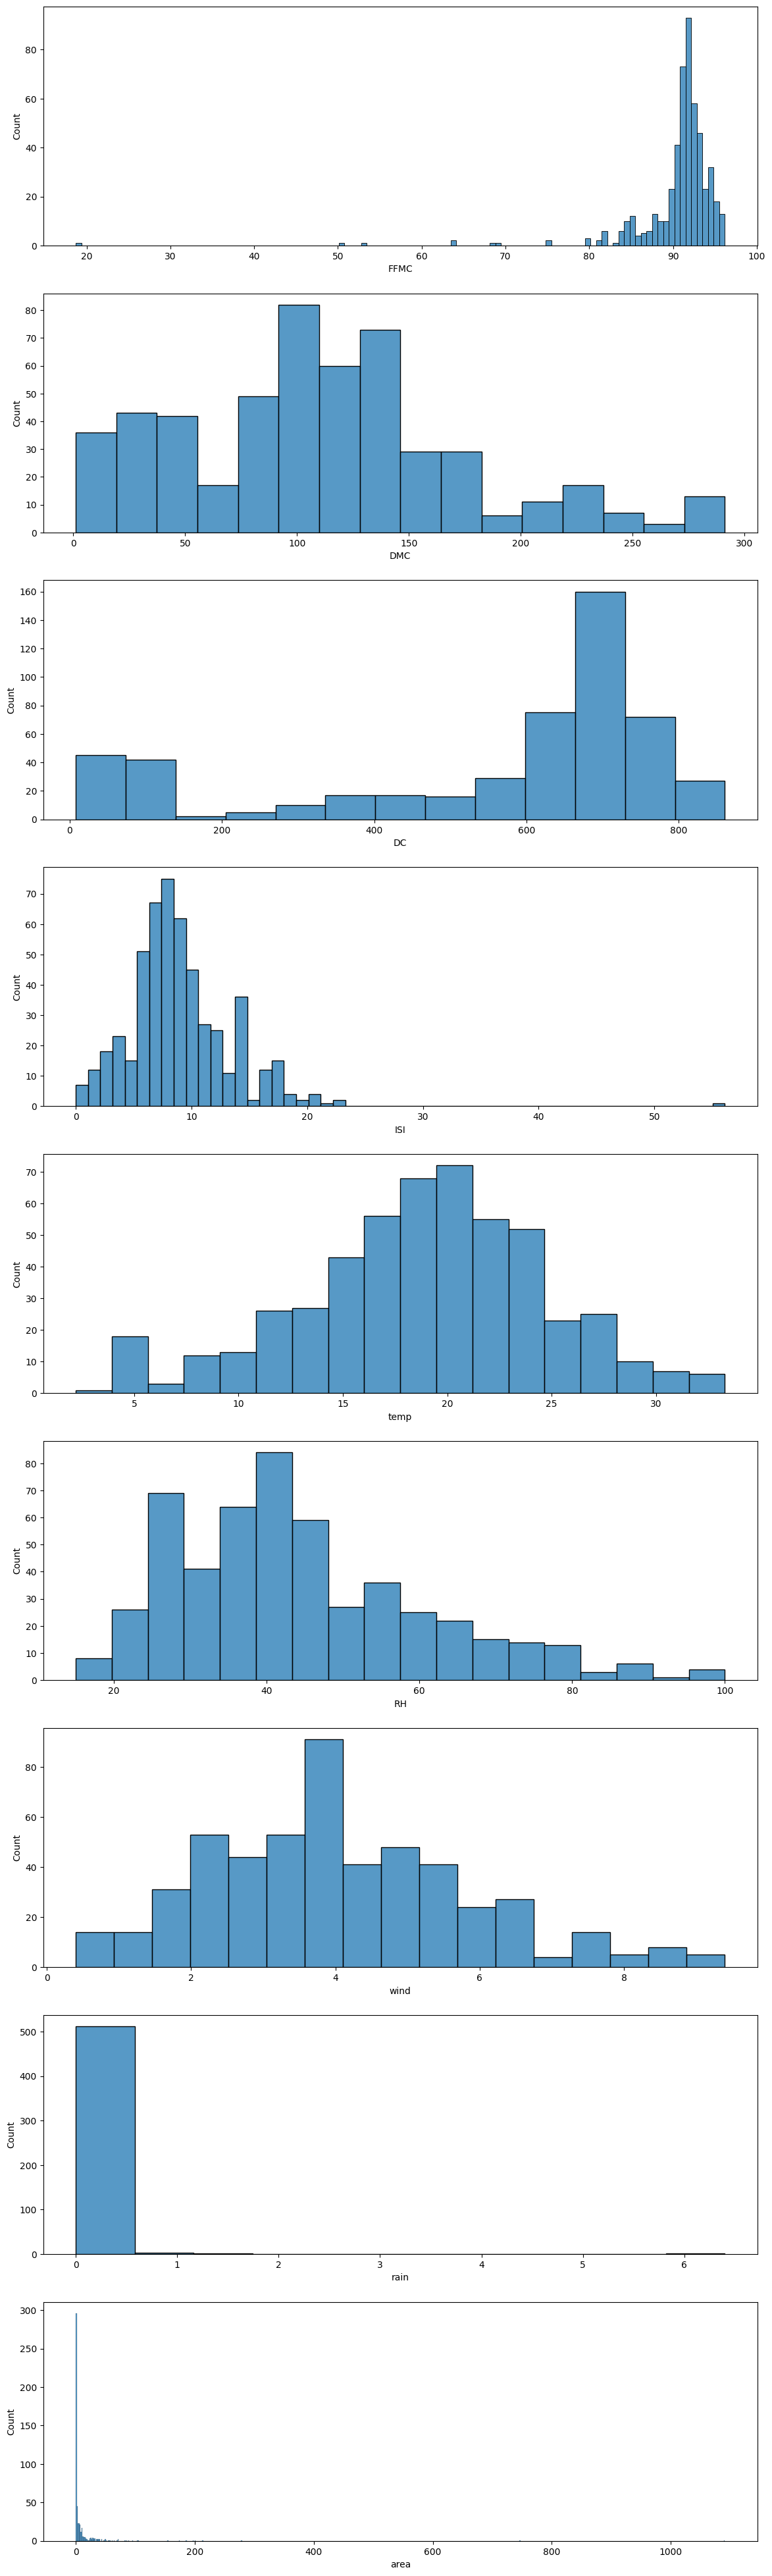

In [11]:
# for numerical_features -- histogram
fig, axes=plt.subplots(len(numeric_features),1,figsize=(14,50))

for i in range (0, len(numeric_features)):
    sns.histplot(data[numeric_features[i]],ax=axes[i])

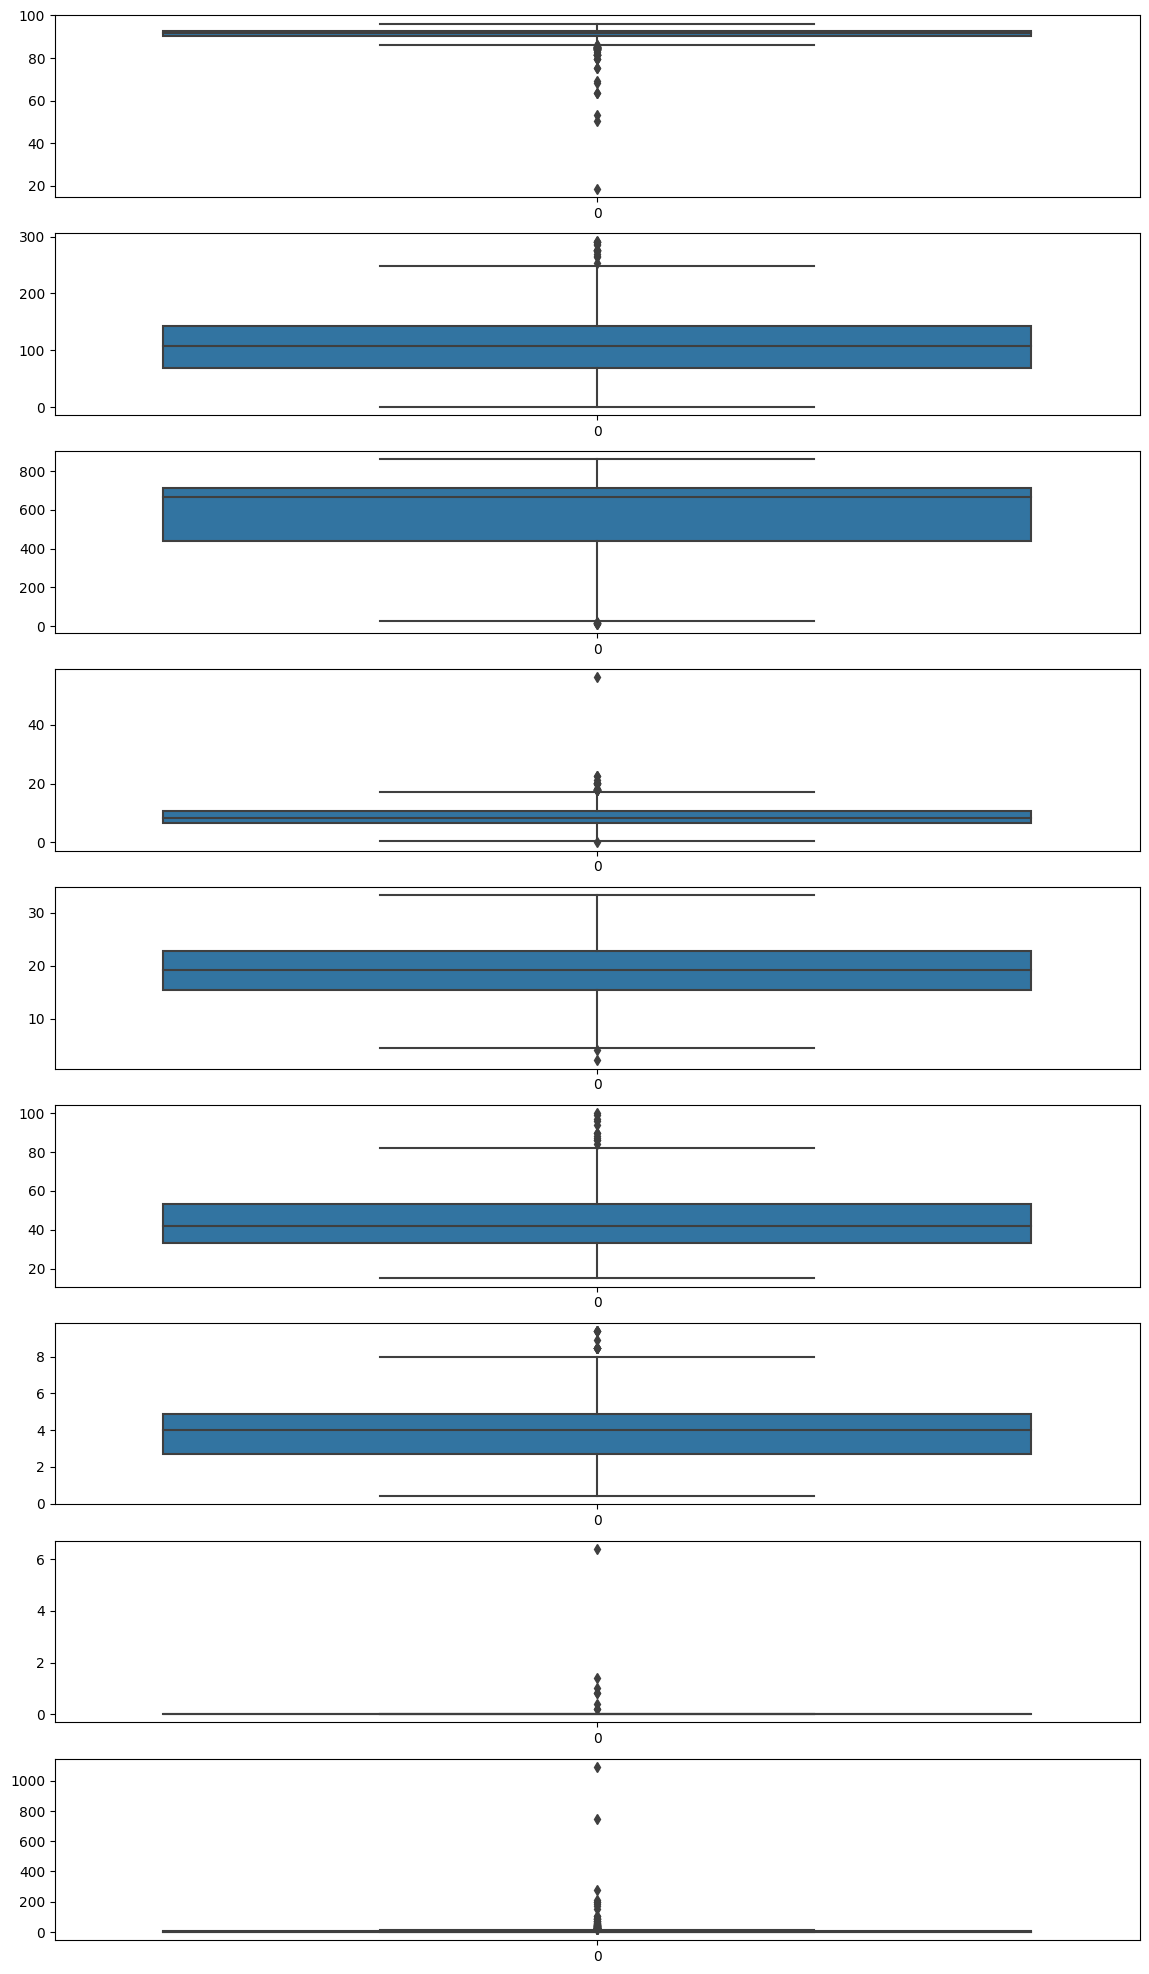

In [14]:

# for outlier detection-- boxplot
fig, axes=plt.subplots(len(numeric_features),1,figsize=(14,25))

for i in range (0, len(numeric_features)):
    sns.boxplot(data[numeric_features[i]],ax=axes[i])

<Axes: >

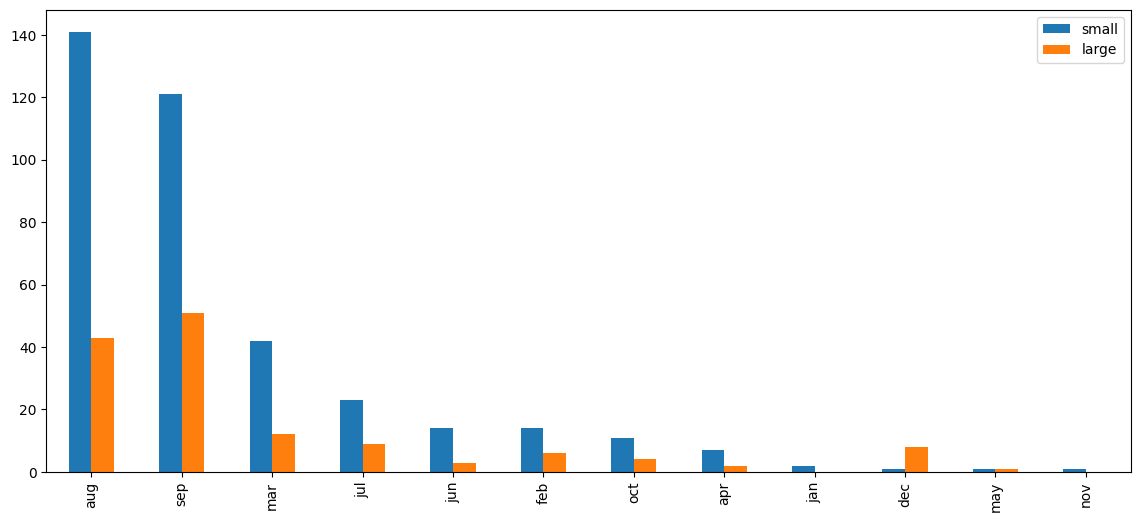

In [15]:

#univariate analysis
# 1) in absolute numbers
df = pd.DataFrame()

df['small'] = raw_data[raw_data['size_category'] == 'small']['month'].value_counts()
df['large'] = raw_data[raw_data['size_category'] == 'large']['month'].value_counts()
    
df.plot.bar(figsize=(14,6)) 

<Axes: >

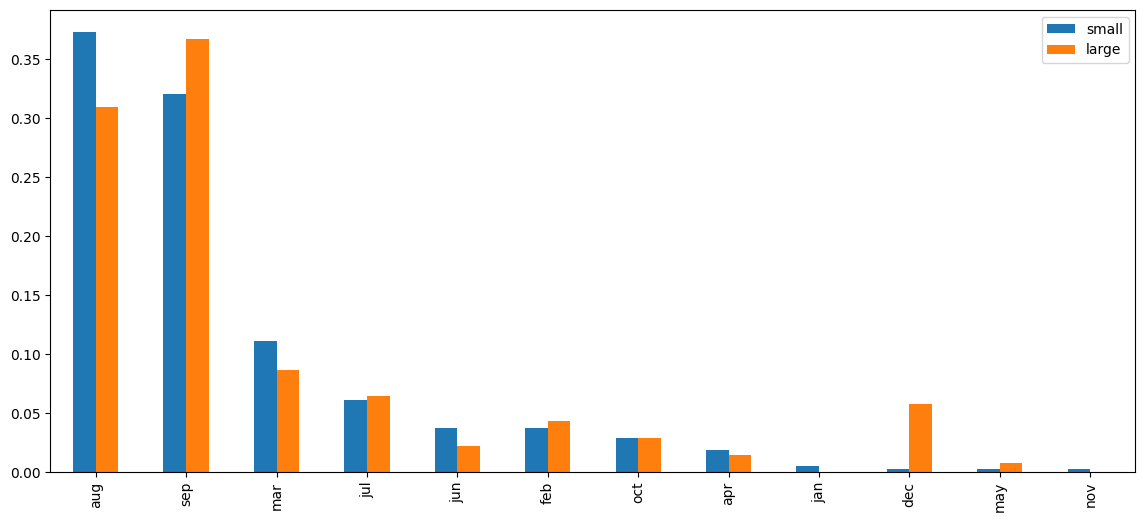

In [16]:

#2) in percentage
df['small'] = raw_data[raw_data['size_category'] == 'small']['month'].value_counts(normalize=True)
df['large'] = raw_data[raw_data['size_category'] == 'large']['month'].value_counts(normalize=True)
    
df.plot.bar(figsize=(14,6)) 

**Data Pre-Processing**

In [17]:
x = data.copy()
x.drop('size_category',axis=1, inplace =True)

y = data[['size_category']]
# encoding output 
le = LabelEncoder()
y = le.fit_transform(y) 

# small : 1, large: 0 
#inputs are already encoded, just need to drop month and day columns
x.drop(['month' , 'day'] , axis=1, inplace=True)  
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=9) 
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)  

Shape of X_train:  (361, 28)
Shape of X_test:  (156, 28)
Shape of y_train:  (361,)
Shape of y_test (156,)


Models in Keras are defined as a sequence of layers.

We create a Sequential model and add layers one at a time Fully connected layers are defined using the Dense class.

You can specify the number of neurons or nodes in the layer as the first argument and the activation function using the activation argument. input_shape = no. of input features Initializations define the way to set the initial random weights of Keras layers

sigmoid on the output layer ensures your network output is between 0 and Linear on output layer ensures

When compiling, you must specify some additional properties required when training the network. Remember training a network means finding the best set of weights to map inputs to outputs in your dataset.

You must specify the loss function to use to evaluate a set of weights, the optimizer used to search through different weights for the network, and any optional metrics you want to collect and report during training.

Regression Loss Functions Mean Squared Error Loss Mean Squared Logarithmic Error Loss Mean Absolute Error Loss

Binary Classification Loss Functions Binary Cross-Entropy Hinge Loss Squared Hinge Loss

Multi-Class Classification Loss Functions Multi-Class Cross-Entropy Loss Sparse Multiclass Cross-Entropy Loss Kullback Leibler Divergence Loss

You can train or fit your model on your loaded data by calling the fit() function on the model. The training process will run for a fixed number of epochs (iterations) through the dataset that you must specify using the epochs argument. You must also set the number of dataset rows that are considered before the model weights are updated within each epoch, called the batch size, and set using the batch_size argument.

The evaluate() function will return a list with two values. The first will be the loss of the model on the dataset, and the second will be the accuracy of the model on the dataset. You are only interested in reporting the accuracy so ignore the loss value.

**Building Model for ANN**

In [18]:
model = Sequential()
model.add(Dense(32,input_dim=28,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(96,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(96,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(96,activation="relu"))
model.add(Dense(1,activation="sigmoid")) 

In [19]:
adam=Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',optimizer = adam,metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=20, validation_split=0.3, epochs = 100, verbose=-1)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

In [20]:
pred = model.predict(x_test) 

5/5 [==============================] - 0s 3ms/step


In [21]:

pred[:5] # model predicted output in the form of probability

array([[9.1707540e-01],
       [1.1879837e-03],
       [9.9793679e-01],
       [9.9683410e-01],
       [2.8367895e-19]], dtype=float32)

In [22]:
predicted = []
for i in range(0, len(pred)):
    if pred[i]<0.5: #converting prob into 1 or 0
        predicted.append(0)
    else:
        predicted.append(1)

In [23]:
print('actual y is :', y_test[:5] ,'\n', 'predicted y is:', predicted[:5]) 

actual y is : [1 0 1 1 0] 
 predicted y is: [1, 0, 1, 1, 0]


In [24]:
from sklearn.metrics import accuracy_score 

accuracy = accuracy_score(y_test, predicted)
print('Accuracy of model is:', accuracy) 

Accuracy of model is: 0.9743589743589743


In [25]:

from sklearn.metrics import confusion_matrix , classification_report
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        45
           1       0.99      0.97      0.98       111

    accuracy                           0.97       156
   macro avg       0.96      0.98      0.97       156
weighted avg       0.98      0.97      0.97       156



<Axes: >

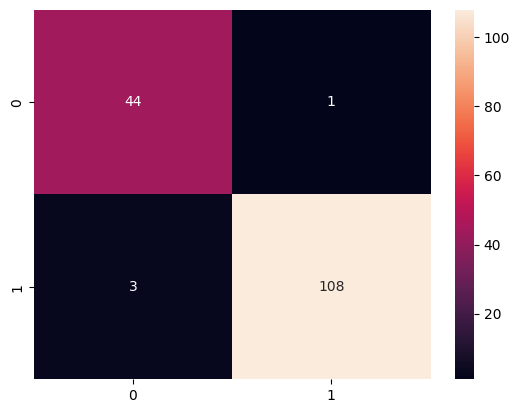

In [26]:

sns.heatmap(confusion_matrix(y_test, predicted), annot=True, fmt='d')